<a href="https://colab.research.google.com/github/danipiazza/Finding-Similar-Items/blob/main/Similar_items.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, size, explode
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, MinHashLSH, HashingTF
from pyspark.sql.types import  ArrayType, StringType

import html
!pip install langid
import langid
import re
import difflib
import math
import seaborn as sns


from google.colab import files

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941171 sha256=a3ac112d0d4e71616eea9256ee1aa823d8b85534bac07531fb682e467a7d58a0
  Stored in directory: /root/.cache/pip/wheels/32/6a/b6/b7eb43a6ad55b139c15c5daa29f3707659cfa6944d3c696f5b
Successfully built langid


In [2]:
kaggle_path = os.path.expanduser("~/.kaggle/kaggle.json")
files.upload()


!ls -lha kaggle.json
!pip install -q kaggle # installing the kaggle package
!mkdir -p ~/.kaggle # creating .kaggle folder where the key should be placed
!cp kaggle.json ~/.kaggle/ # move the key to the folder
!pwd # checking the present working directory
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mohamedbakhet/amazon-books-reviews
!unzip *amazon-books-reviews.zip

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 69 Jul  8 22:11 kaggle.json
/content
Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
 98% 1.05G/1.06G [00:09<00:00, 264MB/s]
100% 1.06G/1.06G [00:09<00:00, 126MB/s]
Archive:  amazon-books-reviews.zip
  inflating: Books_rating.csv        
  inflating: books_data.csv          


In [3]:
spark = SparkSession.builder.appName("Similar Reviews").getOrCreate()
sc = spark.sparkContext

In [4]:
df = spark.read.csv("Books_rating.csv", header=True, inferSchema=True, quote='"', escape='"')

In [ ]:
df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- User_id: string (nullable = true)
 |-- profileName: string (nullable = true)
 |-- review/helpfulness: string (nullable = true)
 |-- review/score: double (nullable = true)
 |-- review/time: integer (nullable = true)
 |-- review/summary: string (nullable = true)
 |-- review/text: string (nullable = true)



In [ ]:
full_count = df.count()
print(f"Total number of reviews: {full_count}")

Total number of reviews: 3000000


In [ ]:
# Variables to control if we want to sample the data:
# Ture if we want to sample the data, False if we want to use the entire dataset
SAMPLE = True
# SAMPLE_FRACTION is the fraction of the data to sample, e.g., 0.05 means 5% of the data will be sampled
SAMPLE_FRACTION = 0.05

if SAMPLE:
    df = df.sample(fraction=SAMPLE_FRACTION, seed=59)

In [ ]:
df.show(10, truncate=False)

+----------+------------------------------------------------------------------------------------------------------------------------+-----+--------------+---------------------------+------------------+------------+-----------+---------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
initial_count = df.count()
print(f"Initial count: {initial_count}")

Initial count: 150088


In [ ]:
df = df.select("Id", "Title", "User_id", "review/text")

In [ ]:
# user defined function to decode html entities (e.g. &amp; to &)
decode_udf = udf(lambda text: html.unescape(text) if text else text, StringType())

In [ ]:
df = df.withColumn("review/text", decode_udf(col("review/text")))

In [ ]:
# lowercase review/text:
lowercase_udf = udf(lambda text: text.lower() if text else text, StringType())
df = df.withColumn("review_clean", lowercase_udf(col("review/text")))

In [ ]:
# remove special characters
def remove_special_char(text):
    text = re.sub(r"[^a-z0-9 ]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()
remove_special_char_udf = udf(remove_special_char, StringType())

In [ ]:
df = df.withColumn("review_clean", remove_special_char_udf(col("review_clean")))

In [ ]:
# remove duplicates based on review_clean as their similarity will be 1
df = df.dropDuplicates(["review_clean"])

In [ ]:
without_duplicates_count = df.count()
print(f"Removed {initial_count - without_duplicates_count} duplicates based on review_clean")
print(f"Final count: {without_duplicates_count}")

Removed 6909 duplicates based on review_clean
Final count: 143179


In [ ]:
# user defined function find the language of the text, I used the first 50 words to make it faster
lang_udf = udf(lambda text: langid.classify(" ".join(text.split()[:50]))[0], StringType())

In [ ]:
df = df.withColumn("language", lang_udf(col("review_clean")))
df.groupBy("language").count().orderBy(col("count").desc()).show()

+--------+------+
|language| count|
+--------+------+
|      en|142903|
|      es|   199|
|      fr|    17|
|      pt|    10|
|      de|     9|
|      it|     6|
|      nl|     4|
|      no|     3|
|      mt|     3|
|      an|     3|
|      pl|     2|
|      tr|     2|
|      zu|     2|
|      la|     2|
|      da|     2|
|      id|     2|
|      sk|     1|
|      tl|     1|
|      mg|     1|
|      sl|     1|
+--------+------+
only showing top 20 rows


In [ ]:
# Filter out non English reviews
df = df.filter(col("language") == "en")
df = df.drop("language")

In [ ]:
# RegexTokenizer transforms the text into a list of words
tokenizer = RegexTokenizer(inputCol="review_clean", outputCol="tokens", pattern="\\W+")
# StopWordsRemover removes common words that do not add much meaning to the text
stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")

# User defined function to create shingles of size k. Shingle based on the words in the review
def shingle(words, k=3):
    return list(set(" ".join(words[i:i+k]) for i in range(len(words)-k+1))) # set to avoid duplicates and then return as a list so that Spark can handle it properly

shingle_udf = udf(lambda words: shingle(words, 3), ArrayType(StringType()))

pipeline = Pipeline(stages=[tokenizer,stopwords_remover])

In [ ]:
df = pipeline.fit(df).transform(df)
df = df.withColumn("token_count", size(col("filtered_tokens")))

In [ ]:
data = df.select("token_count").toPandas()["token_count"]
data.describe()

count    142903.000000
mean         74.068284
std          85.436116
min           1.000000
25%          24.000000
50%          47.000000
75%          91.000000
max        2887.000000
Name: token_count, dtype: float64

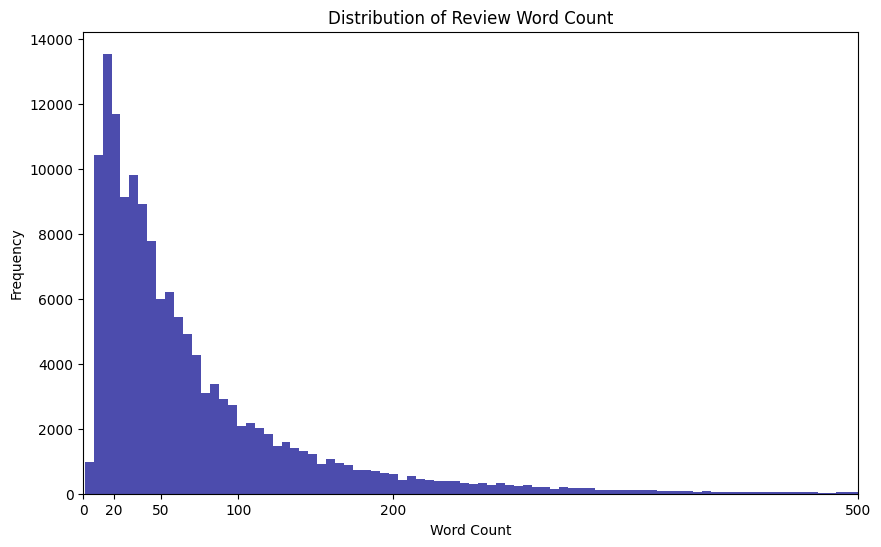

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(data, bins=500, color='darkblue', alpha=0.7)
plt.title("Distribution of Review Word Count")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.xlim(0, 500)
plt.xticks([0, 20, 50, 100, 200, 500])
plt.show()

In [ ]:
df = df.filter((col("token_count") >= 20) & (col("token_count") <= 200))

In [ ]:
long_filtered_count = df.count()
print(f"Filtered out {without_duplicates_count - long_filtered_count} reviews with less than 20 or more than 200 words")
print(f"Final count after filtering: {long_filtered_count}")

Filtered out 36954 reviews with less than 20 or more than 200 words
Final count after filtering: 106225


In [ ]:
df = df.withColumn("shingles", shingle_udf(col("filtered_tokens")))

In [ ]:
unique_terms = df.select(explode("shingles")).distinct().count()
print(unique_terms)

6359818


In [ ]:
# Calculate the number of features for HashingTF
# We want the number of features to be a power of 2 that is greater than the size of unique terms
power = math.ceil(math.log2(unique_terms))
print(f"Power for HashingTF: {power}")
numFeatures = 2 ** power
print(f"Number of features for HashingTF: {numFeatures}")

Power for HashingTF: 23
Number of features for HashingTF: 8388608


In [ ]:
hashing_tf = HashingTF(inputCol="shingles", outputCol="tf_features", numFeatures=numFeatures)

In [ ]:
df = hashing_tf.transform(df)

In [ ]:
minhash = MinHashLSH(inputCol="tf_features", outputCol="hashes", numHashTables=30)

In [ ]:
minhash_model = minhash.fit(df)

In [ ]:
similar_pairs = minhash_model.approxSimilarityJoin(
    df, df, threshold=0.7, distCol="JaccardDistance"
)

In [ ]:
similar_pairs = similar_pairs.filter(col("datasetA.Id") > col("datasetB.Id"))

In [ ]:
similar_order = similar_pairs.orderBy("JaccardDistance", ascending=True).cache()

In [ ]:
similar_order.select((1 - col("JaccardDistance")).alias("JaccardSimilarity"),
    *[col(f"datasetA.{c}").alias(f"{c}A") for c in similar_order.select("datasetA.*").columns],
    *[col(f"datasetB.{c}").alias(f"{c}B") for c in similar_order.select("datasetB.*").columns]).show(50, truncate=False)

+------------------+----------+----------------------------------------------------------------+--------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
cols = ["User_id", "Title", "review/text"]

select_expr = [(1 - col("JaccardDistance")).alias("JaccardSimilarity")]

for c in cols:
    select_expr.append(col(f"datasetA.{c}").alias(f"{c}A"))
    select_expr.append(col(f"datasetB.{c}").alias(f"{c}B"))

similar_order.select(*select_expr).show(50, truncate=False)

+------------------+--------------+--------------+----------------------------------------------------------------+------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
cols = df.columns

select_expr = [(1 - col("JaccardDistance")).alias("JaccardSimilarity")]
for c in cols:
    select_expr.append(col(f"datasetA.{c}").alias(f"{c}A"))
    select_expr.append(col(f"datasetB.{c}").alias(f"{c}B"))

sim_df = similar_order.select(*select_expr).toPandas()


In [ ]:
sim_df.head(10)

,JaccardSimilarity,IdA,IdB,TitleA,TitleB,User_idA,User_idB,review/textA,review/textB,review_cleanA,...,tokensA,tokensB,filtered_tokensA,filtered_tokensB,token_countA,token_countB,shinglesA,shinglesB,tf_featuresA,tf_featuresB
0,1.000000,B000NWO8CG,B0007H73LU,A Tree Grows in Brooklyn,A tree grows in Brooklyn: A novel (Armed Servi...,A1MRB97AKTR86P,AOI89A87V9PMM,Hello! ...I've read most of the reviews on her...,Hello! ...I've read most of the reviews on her...,hello i ve read most of the reviews on here th...,...,"[hello, i, ve, read, most, of, the, reviews, o...","[hello, i, ve, read, most, of, the, reviews, o...","[hello, ve, read, reviews, range, 4, 5, stars,...","[hello, ve, read, reviews, range, 4, 5, stars,...",133,133,"[times find crying, nolan reminded father, new...","[times find crying, nolan reminded father, new...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1.000000,B000NWQXBA,B000GQG7D2,The Hobbit,The Hobbit,ACFOTAO0A7E3Y,None,J.R.R Tolkien's Hobbit is not only the best bo...,J.R.R Tolkien's Hobbit is not only the best bo...,j r r tolkien s hobbit is not only the best bo...,...,"[j, r, r, tolkien, s, hobbit, is, not, only, t...","[j, r, r, tolkien, s, hobbit, is, not, only, t...","[j, r, r, tolkien, hobbit, best, book, written...","[j, r, r, tolkien, hobbit, best, book, written...",78,78,"[make want read, r r tolkien, read might even,...","[make want read, r r tolkien, read might even,...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1.000000,B000Q91194,B000O1UCCQ,Clan of the Cave Bear (Earth's Children),The Clan of the Cave Bear,A1Y87E22UVYCE6,A1Y87E22UVYCE6,This is a marvelous book; it deals with Ice Ag...,This is a marvelous book; it deals with Ice Ag...,this is a marvelous book it deals with ice age...,...,"[this, is, a, marvelous, book, it, deals, with...","[this, is, a, marvelous, book, it, deals, with...","[marvelous, book, deals, ice, age, coexistence...","[marvelous, book, deals, ice, age, coexistence...",96,96,"[neanderthal female point, every minute ms, te...","[neanderthal female point, every minute ms, te...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1.000000,B0008CVEW8,0748608370,Robert Louis Stevenson's Treasure island,Treasure Island,None,ANFHSXHXDYFUN,I thought that it was a good book. I liked how...,I thought that it was a good book. I liked how...,i thought that it was a good book i liked how ...,...,"[i, thought, that, it, was, a, good, book, i, ...","[i, thought, that, it, was, a, good, book, i, ...","[thought, good, book, liked, author, described...","[thought, good, book, liked, author, described...",22,22,"[changed character often, character often rema...","[changed character often, character often rema...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1.000000,B000Q032UY,B000NDSX6C,The Hobbit or There and Back Again,The Hobbit,A2ORLF4C88HDUJ,A2ORLF4C88HDUJ,Whereas other reviews have focused on Tolkien'...,Whereas other reviews have focused on Tolkien'...,whereas other reviews have focused on tolkien ...,...,"[whereas, other, reviews, have, focused, on, t...","[whereas, other, reviews, have, focused, on, t...","[whereas, reviews, focused, tolkien, excellent...","[whereas, reviews, focused, tolkien, excellent...",99,99,"[long fan lord, two tolkien illustrators, grea...","[long fan lord, two tolkien illustrators, grea...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,0.986842,B00006SL45,1850891648,Frankenstein,Frankenstein (Isis Large Print Fiction),A20EEWWSFMZ1PN,A20EEWWSFMZ1PN,Victor grew up reading the works of Paracelsus...,Victor grew up reading the works of Paracelsus...,victor grew up reading the works of paracelsus...,...,"[victor, grew, up, reading, the, works, of, pa...","[victor, gr

In [ ]:
# export to csv so that we can analyze it later
sim_df.to_csv("similar_reviews.csv", index=False)

In [ ]:
sim_df = pd.read_csv("similar_reviews.csv")
sim_df.head(10)

,JaccardSimilarity,IdA,IdB,TitleA,TitleB,User_idA,User_idB,review/textA,review/textB,review_cleanA,...,tokensA,tokensB,filtered_tokensA,filtered_tokensB,token_countA,token_countB,shinglesA,shinglesB,tf_featuresA,tf_featuresB
0,1.000000,B000NWO8CG,B0007H73LU,A Tree Grows in Brooklyn,A tree grows in Brooklyn: A novel (Armed Servi...,A1MRB97AKTR86P,AOI89A87V9PMM,Hello! ...I've read most of the reviews on her...,Hello! ...I've read most of the reviews on her...,hello i ve read most of the reviews on here th...,...,"['hello', 'i', 've', 'read', 'most', 'of', 'th...","['hello', 'i', 've', 'read', 'most', 'of', 'th...","['hello', 've', 'read', 'reviews', 'range', '4...","['hello', 've', 'read', 'reviews', 'range', '4...",133,133,"['times find crying', 'nolan reminded father',...","['times find crying', 'nolan reminded father',...","(8388608,[63303,89124,195015,217245,335564,336...","(8388608,[63303,89124,195015,217245,335564,336..."
1,1.000000,B000NWQXBA,B000GQG7D2,The Hobbit,The Hobbit,ACFOTAO0A7E3Y,NaN,J.R.R Tolkien's Hobbit is not only the best bo...,J.R.R Tolkien's Hobbit is not only the best bo...,j r r tolkien s hobbit is not only the best bo...,...,"['j', 'r', 'r', 'tolkien', 's', 'hobbit', 'is'...","['j', 'r', 'r', 'tolkien', 's', 'hobbit', 'is'...","['j', 'r', 'r', 'tolkien', 'hobbit', 'best', '...","['j', 'r', 'r', 'tolkien', 'hobbit', 'best', '...",78,78,"['make want read', 'r r tolkien', 'read might ...","['make want read', 'r r tolkien', 'read might ...","(8388608,[25892,269383,322207,414867,689729,74...","(8388608,[25892,269383,322207,414867,689729,74..."
2,1.000000,B000Q91194,B000O1UCCQ,Clan of the Cave Bear (Earth's Children),The Clan of the Cave Bear,A1Y87E22UVYCE6,A1Y87E22UVYCE6,This is a marvelous book; it deals with Ice Ag...,This is a marvelous book; it deals with Ice Ag...,this is a marvelous book it deals with ice age...,...,"['this', 'is', 'a', 'marvelous', 'book', 'it',...","['this', 'is', 'a', 'marvelous', 'book', 'it',...","['marvelous', 'book', 'deals', 'ice', 'age', '...","['marvelous', 'book', 'deals', 'ice', 'age', '...",96,96,"['neanderthal female point', 'every minute ms'...","['neanderthal female point', 'every minute ms'...","(8388608,[40717,94541,109111,128783,207492,254...","(8388608,[40717,94541,109111,128783,207492,254..."
3,1.000000,B0008CVEW8,0748608370,Robert Louis Stevenson's Treasure island,Treasure Island,NaN,ANFHSXHXDYFUN,I thought that it was a good book. I liked how...,I thought that it was a good book. I liked how...,i thought that it was a good book i liked how ...,...,"['i', 'thought', 'that', 'it', 'was', 'a', 'go...","['i', 'thought', 'that', 'it', 'was', 'a', 'go...","['thought', 'good', 'book', 'liked', 'author',...","['thought', 'good', 'book', 'liked', 'author',...",22,22,"['changed character often', 'character often r...","['changed character often', 'character often r...","(8388608,[249262,624769,1097229,1572509,217284...","(8388608,[249262,624769,1097229,1572509,217284..."
4,1.000000,B000Q032UY,B000NDSX6C,The Hobbit or There and Back Again,The Hobbit,A2ORLF4C88HDUJ,A2ORLF4C88HDUJ,Whereas other reviews have focused on Tolkien'...,Whereas other reviews have focused on Tolkien'...,whereas other reviews have focused on tolkien ...,...,"['whereas', 'other', 'reviews', 'have', 'focus...","['whereas', 'other', 'reviews', 'have', 'focus...","['whereas', 'reviews', 'focused', 'tolkien', '...","['whereas', 'reviews', 'focused', 'tolkien', '...",99,99,"['long fan lord', 'two tolkien illustrators', ...","['long fan lord', 'two tolkien illustrators', ...","(8388608,[67040,228503,311368,422341,430569,54...","(8388608,[67040,228503,311368,422341,430569,54..."
5,0.986842,B00006SL45,1850891648,Frankenstein,Frankenstein (Isis Large Print Fiction),A20EEWWSFMZ1PN,A20EEWWSFMZ1PN,Victor grew up reading the works of Paracelsus...,Victor grew up reading the works of Paracelsus...,victor grew up reading the works of paracelsus...,...,"['victor', 'grew', 'up', 'reading', 'the', 'wo...","['victor', 'g

In [ ]:
# Analyze the similarities
for _, row in sim_df.iterrows():
    if row.JaccardSimilarity < 0.8:
        break

    print(f"Similarity: {row.JaccardSimilarity}")
    same_user = row.User_idA == row.User_idB
    print(f"Same User: {same_user}")
    same_title = row.TitleA == row.TitleB
    print(f"Same Title: {same_title}")
    print("-"*50)
    print("Length of ReviewA: ", len(row['review/textA'].split()))
    print("Length of ReviewB: ", len(row['review/textB'].split()))
    print("-"*50)
    print(f"TitleA: {row.TitleA}")
    print(f"TitleB: {row.TitleB}")
    print("-"*50)
    print(f"Review A: {row['review/textA']}")
    print(f"Review B: {row['review/textB']}")
    print("-"*50)

    # Split the reviews into words for comparison
    reviewA = row['review_cleanA'].split()
    reviewB = row['review_cleanB'].split()

    diff = difflib.ndiff(reviewA, reviewB)
    print("DIFFERENCES:")
    for word in diff:
        if word.startswith("- "):
            print(f"\033[91m{word}\033[0m", end='')  # red for words removed
        elif word.startswith("+ "):
            print(f"\033[92m{word}\033[0m", end='')  # green for words added
        else:
            print(word, end='')
    print("\n" + "="*50 + "\n")

Similarity: 1.0
Same User: False
Same Title: False
--------------------------------------------------
Length of ReviewA:  274
Length of ReviewB:  275
--------------------------------------------------
TitleA: A Tree Grows in Brooklyn
TitleB: A tree grows in Brooklyn: A novel (Armed Services edition)
--------------------------------------------------
Review A: Hello! ...I've read most of the reviews on here. They range from 4 to 5 stars with an ocassional bad review thrown into the mix (go figure) I cant offer much more than whats alreaddy been said. but what i will offer is from the perspective of a 27 year old guy...For starters, dont even kid yourself into thinking this is for women only,..its not...and you dont have to be a new age sensetive guy either to enjoy the full spectrum of emotions this book will put you through..at times i laffed out loud so hard i thought my belly would burst open...and at other times i would find myself crying and the tears would stream down my face so m

In [ ]:
sim_df[sim_df['JaccardSimilarity'] > 0.8]['token_countA'].describe()

count     53.000000
mean     113.811321
std       37.382666
min       22.000000
25%       86.000000
50%      109.000000
75%      143.000000
max      189.000000
Name: token_countA, dtype: float64

In [ ]:
top_ids = pd.concat([sim_df["IdA"], sim_df["IdB"]]).value_counts().head(20).index.tolist()

In [ ]:
unique_pairs_df = sim_df.drop_duplicates(subset=['IdA', 'IdB'])

In [ ]:
filtered_df = unique_pairs_df[
    (unique_pairs_df['IdA'].isin(top_ids)) & (unique_pairs_df['IdB'].isin(top_ids))
]

In [ ]:
sim_user_matrix = filtered_df.pivot(index='IdA', columns='IdB', values='JaccardSimilarity')

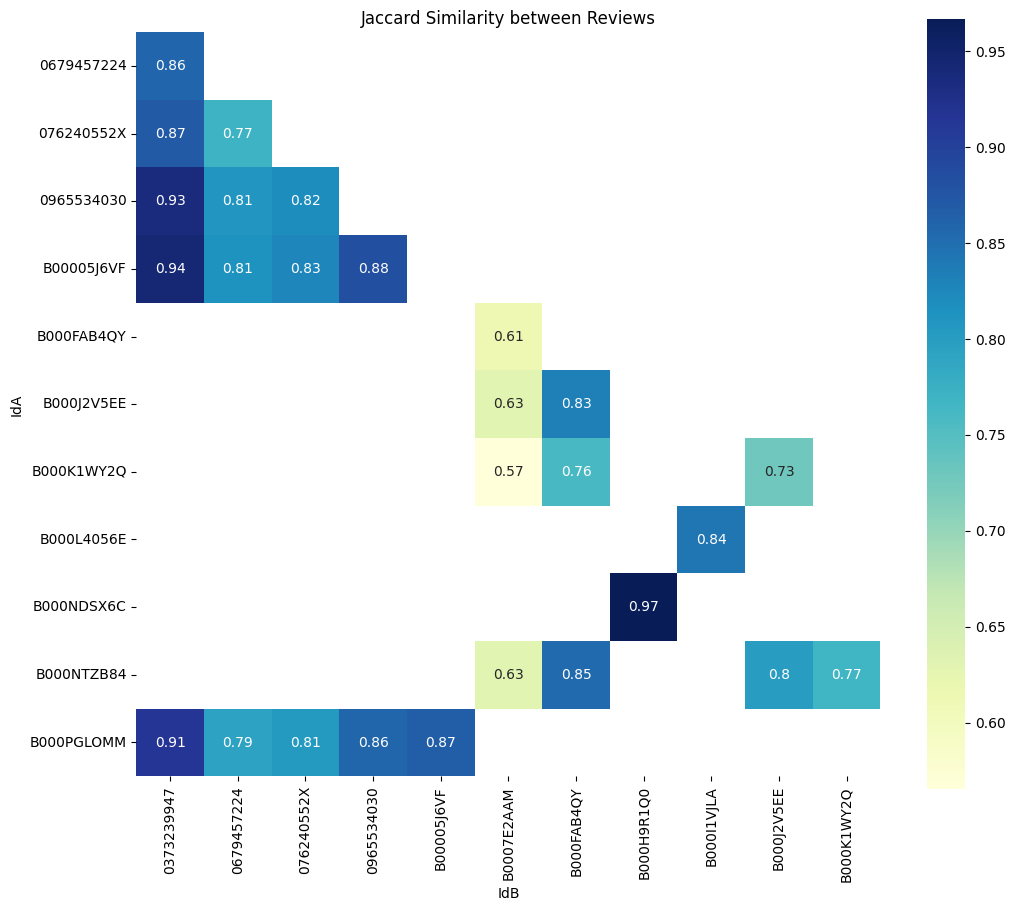

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(sim_user_matrix, annot=True, cmap="YlGnBu", square=True)
plt.title("Jaccard Similarity between Reviews")
plt.show()

In [ ]:
sim_group = sim_df[(sim_df['IdA']=="0373239947") | (sim_df['IdB']=="0373239947")]
sim_group

,JaccardSimilarity,IdA,IdB,TitleA,TitleB,User_idA,User_idB,review/textA,review/textB,review_cleanA,...,tokensA,tokensB,filtered_tokensA,filtered_tokensB,token_countA,token_countB,shinglesA,shinglesB,tf_featuresA,tf_featuresB
16,0.941606,B00005J6VF,0373239947,The Alibi,The Perfect Neighbor (The Macgregors),NaN,NaN,I found this book to be a disapointment to me....,If you want to read a book that goes straight ...,i found this book to be a disapointment to me ...,...,"['i', 'found', 'this', 'book', 'to', 'be', 'a'...","['if', 'you', 'want', 'to', 'read', 'a', 'book...","['found', 'book', 'disapointment', 'bored', 'r...","['want', 'read', 'book', 'goes', 'straight', '...",139,131,"['book disapointment bored', 'moments barbara ...","['moments barbara jeanne', 'quick read got', '...","(8388608,[13234,57849,67545,76932,202137,22904...","(8388608,[13234,57849,67545,76932,202137,22904..."
19,0.934783,0965534030,0373239947,Wild Notion,The Perfect Neighbor (The Macgregors),NaN,NaN,The book was good and showed love as it is rar...,If you want to read a book that goes straight ...,the book was good and showed love as it is rar...,...,"['the', 'book', 'was', 'good', 'and', 'showed'...","['if', 'you', 'want', 'to', 'read', 'a', 'book...","['book', 'good', 'showed', 'love', 'rarely', '...","['want', 'read', 'book', 'goes', 'straight', '...",140,131,"['moments barbara jeanne', 'quick read got', '...","['moments barbara jeanne', 'quick read got', '...","(8388608,[13234,15485,57849,67545,76932,202137...","(8388608,[13234,57849,67545,76932,202137,22904..."
24,0.914894,B000PGLOMM,0373239947,Ulysses.,The Perfect Neighbor (The Macgregors),NaN,NaN,"I thought this was a good book, but hard to ke...",If you want to read a book that goes straight ...,i thought this was a good book but hard to kee...,...,"['i', 'thought', 'this', 'was', 'a', 'good', '...","['if', 'you', 'want', 'to', 'read', 'a', 'book...","['thought', 'good', 'book', 'hard', 'keep', 'i...","['want', 'read', 'book', 'goes', 'straight', '...",143,131,"['moments barbara jeanne', 'quick read got', '...","['moments barbara jeanne', 'quick read got', '...","(8388608,[13234,57849,67545,76932,202137,22904...","(8388608,[13234,57849,67545,76932,202137,22904..."
34,0.870748,076240552X,0373239947,The Scarlet Letter (Courage Unabridged Classics),The Perfect Neighbor (The Macgregors),NaN,NaN,"I thought this was a great book, years ago, an...",If you want to read a book that goes straight ...,i thought this was a great book years ago and ...,...,"['i', 'thought', 'this', 'was', 'a', 'great', ...","['if', 'you', 'want', 'to', 'read', 'a', 'book...","['thought', 'great', 'book', 'years', 'ago', '...","['want', 'read', 'book', 'goes', 'straight', '...",148,131,"['moments barbara jeanne', 'quick read got', '...","['moments barbara jeanne', 'quick read got', '...","(8388608,[13234,16358,57849,67545,76932,136086...","(8388608,[13234,57849,67545,76932,202137,22904..."
39,0.858108,0679457224,0373239947,Until the Real Thing Comes Along:,The Perfect Neighbor (The Macgregors),NaN,NaN,This was certainly different than any other bo...,If you want to read a book that goes straight ...,this was certainly different than any other bo...,...,"['this', 'was', 'certainly', 'different', 'tha...","['if', 'you', 'want', 'to', 'read', 'a', 'book...","['certainly', 'different', 'book', 'ever', 're...","['want', 'read', 'book', 'goes', 'straight', '...",148,131,"['moments barbara jeanne', 'quick read got', '...","['moments barbara jeanne', 'quick read got', '...","(8388608,[13234,67545,76932,202137,229047,3687...","(8388608,[13234,57849,67545,76932,202137,22904..."


In [ ]:
# visualize reviews of sim_group
for _, row in sim_group.iterrows():
    print(f"Similarity: {row.JaccardSimilarity}")
    print("-"*50)
    print(f"TitleA: {row.TitleA}")
    print(f"TitleB: {row.TitleB}")
    print("-"*50)
    print(f"Review A: {row['review/textA']}")
    print(f"Review B: {row['review/textB']}")
    print("-"*50)

Similarity: 0.9416058394160584
--------------------------------------------------
TitleA: The Alibi
TitleB: The Perfect Neighbor (The Macgregors)
--------------------------------------------------
Review A: I found this book to be a disapointment to me. I was bored as I read it, and kept waiting for more to happen. If you want to read a book that goes straight to your heart, read Stolen Moments by Barbara Jeanne Fisher. . .It is a beautiful story of unrequited love. . .for certain the love story of the nineties. I intended to give the book a quick read, but I got so caught up in the story that I couldn't put the book down. From the very beginning, I was fully caught up in the heart-wrenching account of Julie Hunter's battle with lupus and her growing love for Don Lipton. This love, in the face of Julie's impending death, makes for a story that covers the range of human emotions. The touches of humor are great, too, they add some nice contrast and lighten things a bit when emotions are 

SPAM reiviews sponsoring Stolen Moments by Barbara Jeanne Fisher

In [ ]:
mean_sim_by_title = (
    sim_df.groupby(['TitleA', 'TitleB'])['JaccardSimilarity']
    .mean()
    .reset_index()
)

In [ ]:
top_title_pairs = mean_sim_by_title.sort_values(by='JaccardSimilarity', ascending=False).head(15)

In [ ]:
top_titles = pd.unique(top_title_pairs[['TitleA', 'TitleB']].values.ravel())

In [ ]:
sim_title_matrix = mean_sim_by_title[
    (mean_sim_by_title['TitleA'].isin(top_titles)) &
    (mean_sim_by_title['TitleB'].isin(top_titles))
].pivot(index='TitleA', columns='TitleB', values='JaccardSimilarity')

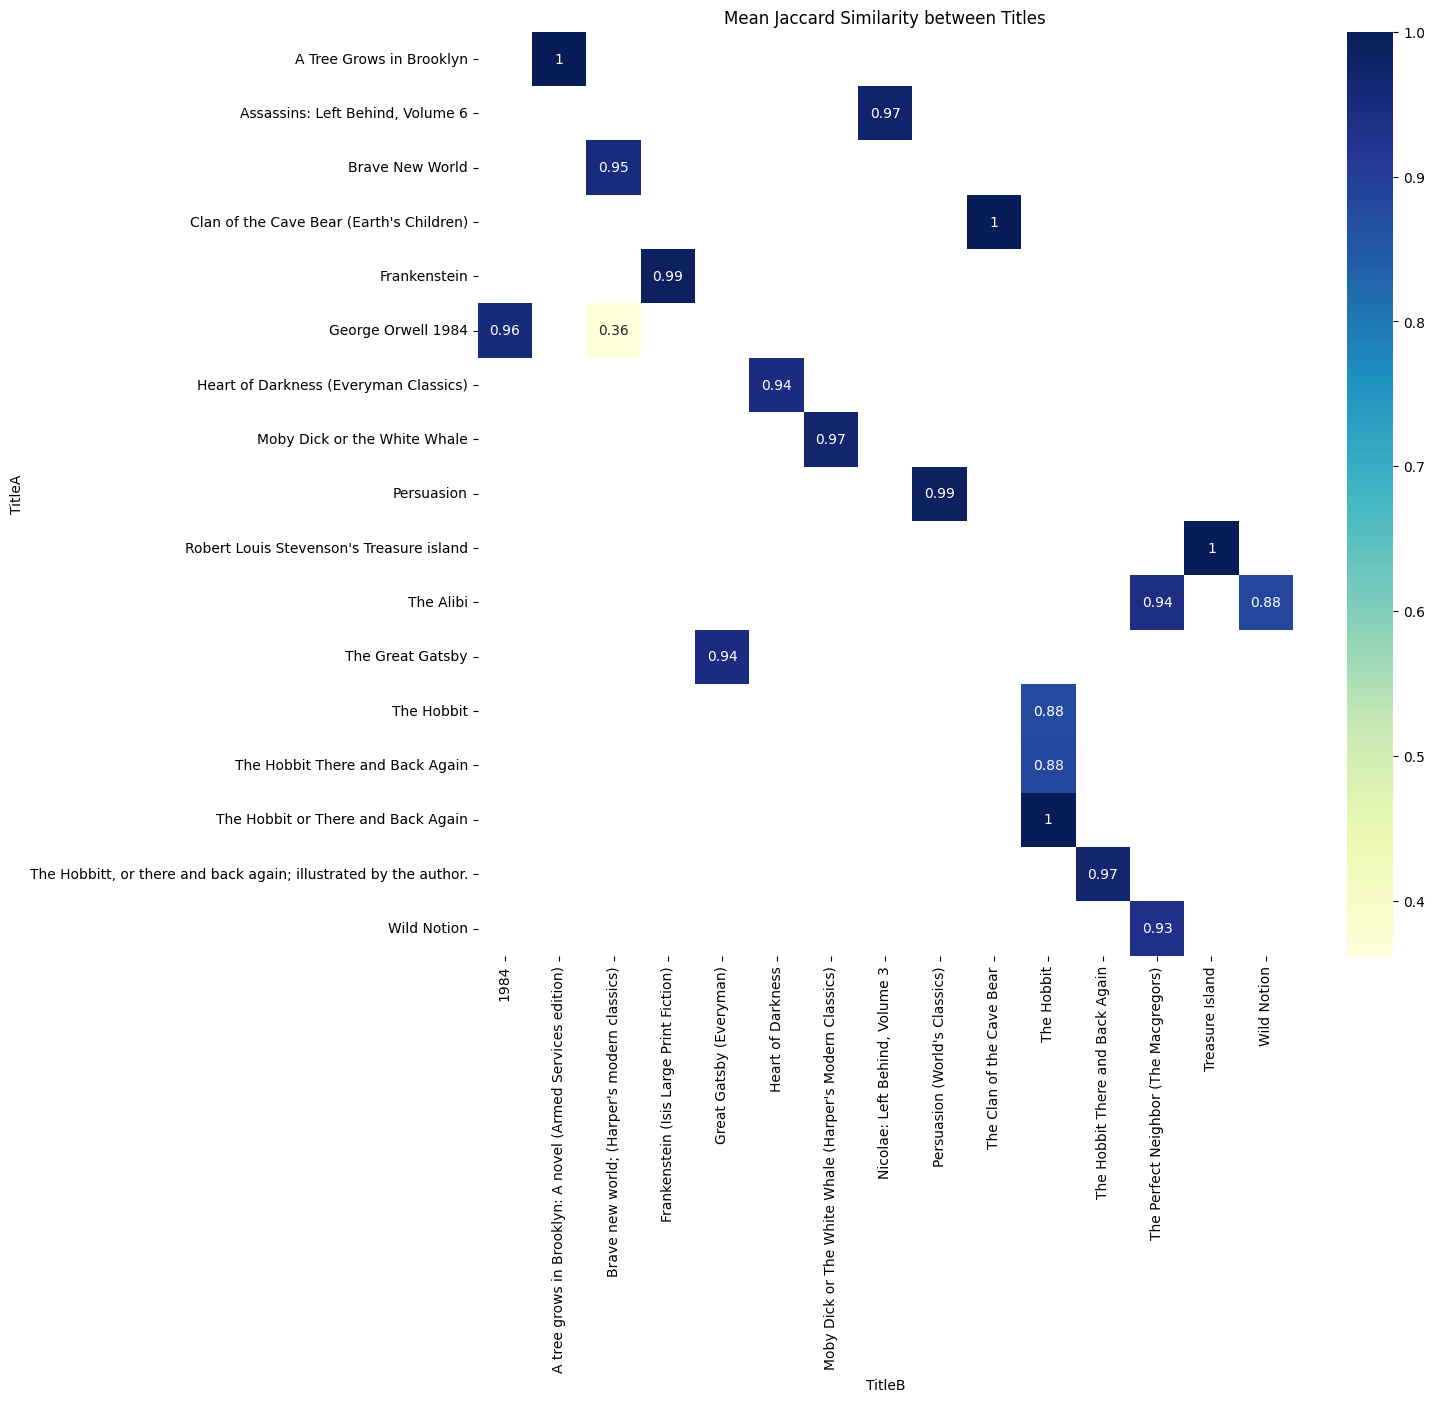

In [ ]:
plt.figure(figsize=(14,12))
sns.heatmap(sim_title_matrix, annot=True, cmap="YlGnBu", square=True)
plt.title("Mean Jaccard Similarity between Titles")
plt.show()


Reviews with similarity >= 0.8: 54 (45.4%)


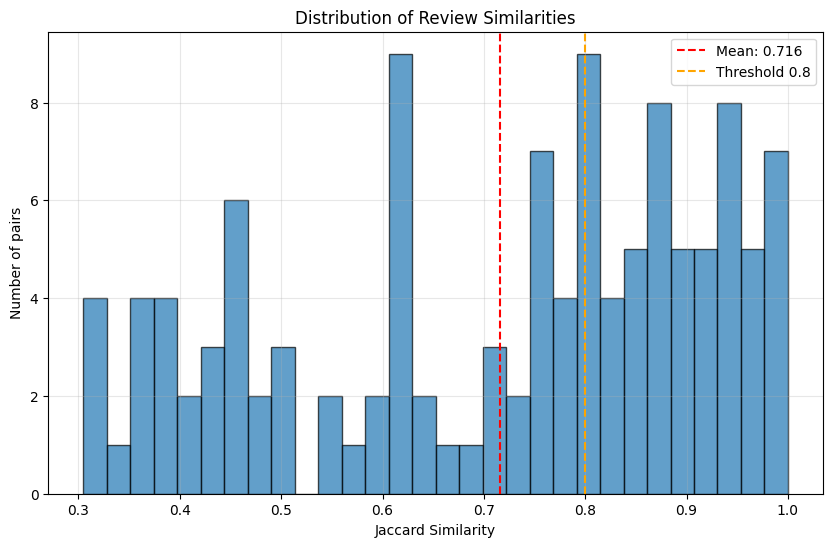

In [ ]:
# Basic analysis on existing data
high_sim = sim_df[sim_df['JaccardSimilarity'] >= 0.8]
print(f"\nReviews with similarity >= 0.8: {len(high_sim)} ({len(high_sim)/len(sim_df)*100:.1f}%)")

plt.figure(figsize=(10, 6))
plt.hist(sim_df['JaccardSimilarity'], bins=30, alpha=0.7, edgecolor='black')
plt.axvline(sim_df['JaccardSimilarity'].mean(), color='red', linestyle='--', label=f'Mean: {sim_df["JaccardSimilarity"].mean():.3f}')
plt.axvline(0.8, color='orange', linestyle='--', label='Threshold 0.8')
plt.xlabel('Jaccard Similarity')
plt.ylabel('Number of pairs')
plt.title('Distribution of Review Similarities')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

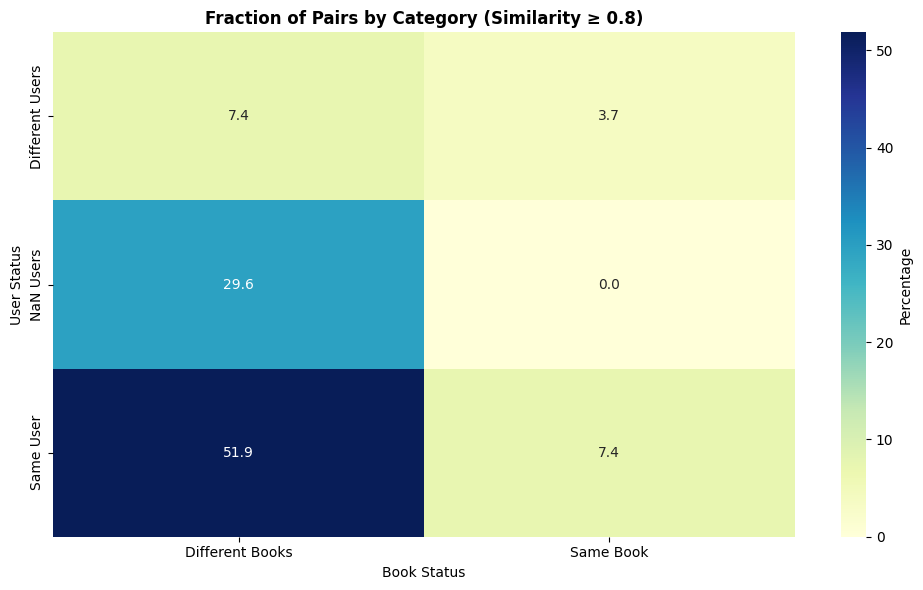

In [ ]:
high_sim_df = sim_df[sim_df['JaccardSimilarity'] >= 0.8].copy()

conditions_user = [
    high_sim_df['User_idA'].isna() & high_sim_df['User_idB'].isna(),
    high_sim_df['User_idA'] == high_sim_df['User_idB']
]
choices_user = ['NaN Users', 'Same User']
high_sim_df['User_Status'] = np.select(conditions_user, choices_user, default='Different Users')

high_sim_df['Title_Status'] = np.where(
    high_sim_df['TitleA'] == high_sim_df['TitleB'], 'Same Book', 'Different Books'
)

filtered_matrix = pd.crosstab(
    high_sim_df['User_Status'],
    high_sim_df['Title_Status']
)

filtered_pct = filtered_matrix.div(filtered_matrix.sum().sum()) * 100

plt.figure(figsize=(10, 6))
sns.heatmap(filtered_pct, annot=True, fmt='.1f', cmap='YlGnBu', cbar_kws={'label': 'Percentage'})
plt.title('Fraction of Pairs by Category (Similarity ≥ 0.8)', fontweight='bold')
plt.ylabel('User Status')
plt.xlabel('Book Status')
plt.tight_layout()
plt.show()

In [ ]:
min_similarity = 0.8
filtered_df = sim_df[sim_df['JaccardSimilarity'] >= min_similarity].copy()

filtered_df = filtered_df.assign(
    title_pair = filtered_df.apply(lambda r: tuple(sorted((r['TitleA'], r['TitleB']))), axis=1),
    same_title = filtered_df['TitleA'] == filtered_df['TitleB'],
    same_user  = filtered_df['User_idA'] == filtered_df['User_idB']
)

In [ ]:
diff_title_pairs = filtered_df[~filtered_df['same_title']]

suspicious = diff_title_pairs[diff_title_pairs['JaccardSimilarity'] >= min_similarity]


grouped = suspicious.groupby('title_pair').agg(
    mean_similarity=('JaccardSimilarity', 'mean'),
    count=('JaccardSimilarity', 'count'),
    same_user_count=('same_user', 'sum')
).round(2)

for (title_a, title_b), row in grouped.iterrows():
    print(f"Suspicious pair (avg similarity: {row.mean_similarity:.2f}):")
    print(f"\tBook A: {title_a}")
    print(f"\tBook B: {title_b}")
    print(f"\tSimilar reviews: {row['count']}")
    print(f"\tSame user: {row.same_user_count}/{row['count']}")

    examples = suspicious[suspicious['title_pair'] == (title_a, title_b)].head(2)
    print("\tExamples:")
    for _, exemple in examples.iterrows():
        print(f"\t\tSim: {exemple['JaccardSimilarity']:.2f}")
        print("\t\tReview A vs B differences:")
        diff = difflib.ndiff(exemple['review/textA'].split(), exemple['review/textB'].split())
        diff_str = ''.join(
            f"\033[91m{word}\033[0m" if word.startswith("- ") else
            f"\033[92m{word}\033[0m" if word.startswith("+ ") else word
            for word in diff
        )
        print(diff_str)
        print("=" * 80)
    print("-" * 80)

Suspicious pair (avg similarity: 0.96):
	Book A: 1984
	Book B: George Orwell 1984
	Similar reviews: 2.0
	Same user: 2.0/2.0
	Examples:
		Sim: 0.97
		Review A vs B differences:
  In  a  society  that  has  eliminated  many  imbalances,  surplus  goods,  and  even  class  struggle,  there  are  bound  to  be  deviates;  Winston  Smith  is  one  of  those.  He  starts  out,  due  to  his  inability  to  doublethink,  with  thoughtcrime.  This  is  in  a  society  that  believes  a  thought  is  as  real  as  the  deed.  Eventually  he  graduates  through  a  series  of  misdemeanors  to  illicit  sex  and  even  plans  to  overthrow  the  very  government  that  took  him  in  as  an  orphan.If  he  gets  caught,  he  will  be  sent  to  the  "Ministry  of  Love"  where  they  have  a  record  of  100%  cures  for  this  sort  of  insanity.  They  will  even  forgive  his  past  indiscretions.Be  sure  to  watch  the  three  different  movies  made  from  this  book:1984  (1954)  Peter  C

In [ ]:
# let's see the steps of the pipeline with a fake review
spark = SparkSession.builder.appName("FakeReview").getOrCreate()
sc = spark.sparkContext
fake_review = spark.createDataFrame([("This book is AMAZING \&amp; I love it!!! Best purchase ever :)",)], ["review/text"])
fake_review.show(truncate=False)

25/07/09 00:05:58 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+--------------------------------------------------------------+
|review/text                                                   |
+--------------------------------------------------------------+
|This book is AMAZING \&amp; I love it!!! Best purchase ever :)|
+--------------------------------------------------------------+



In [ ]:
fake_review = fake_review.withColumn("review/text", decode_udf(col("review/text")))
fake_review = fake_review.withColumn("review_clean", lowercase_udf(col("review/text")))
fake_review = fake_review.withColumn("review_clean", remove_special_char_udf(col("review_clean")))
fake_review = fake_review.withColumn("language", lang_udf(col("review_clean")))
fake_review = pipeline.fit(fake_review).transform(fake_review)
fake_review = fake_review.withColumn("token_count", size(col("filtered_tokens")))
fake_review = fake_review.withColumn("shingles", shingle_udf(col("filtered_tokens")))
fake_review = hashing_tf.transform(fake_review)

In [ ]:
fake_review.select("review_clean").show(truncate=False)

+-------------------------------------------------+
|review_clean                                     |
+-------------------------------------------------+
|this book is amazing i love it best purchase ever|
+-------------------------------------------------+



In [ ]:
fake_review.select("tokens").show(truncate=False)

+------------------------------------------------------------+
|tokens                                                      |
+------------------------------------------------------------+
|[this, book, is, amazing, i, love, it, best, purchase, ever]|
+------------------------------------------------------------+



In [ ]:
fake_review.select("filtered_tokens").show(truncate=False)

+-------------------------------------------+
|filtered_tokens                            |
+-------------------------------------------+
|[book, amazing, love, best, purchase, ever]|
+-------------------------------------------+



In [ ]:
fake_review.select("shingles").show(truncate=False)

+------------------------------------------------------------------------------+
|shingles                                                                      |
+------------------------------------------------------------------------------+
|[best purchase ever, love best purchase, book amazing love, amazing love best]|
+------------------------------------------------------------------------------+



In [ ]:
fake_review.select("tf_features").show(truncate=False)

+-----------------------------------------------------------+
|tf_features                                                |
+-----------------------------------------------------------+
|(8388608,[704307,779930,6655534,8344462],[1.0,1.0,1.0,1.0])|
+-----------------------------------------------------------+



In [ ]:
minhash_model = minhash.fit(fake_review)

In [ ]:
minhash_model.transform(fake_review).show(truncate=False)

+----------------------------------------------------------+-------------------------------------------------+--------+------------------------------------------------------------+-------------------------------------------+-----------+------------------------------------------------------------------------------+-----------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|review/text                                               |review_clean                                     |language|tokens                           